In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
import os
import glob
from matplotlib import rc
import io
import cv2
import datetime
from influxdb import InfluxDBClient # module needed to get access and send query to InfluxDB
import re
rc("font", size=6, weight='bold')

# __Preprocessing Class__

In [2]:
from multiprocessing import Pool
class data_preprocessing():
    '''
    **Fileds**
    _user : 
    _passwd :
    _port :
    _addr :
    _dbname :
    _client :
    
    **Methods**
    
    '''
    def __init__(self, addr, port, username, passwd, dbname):
        self._user = username
        self._port = port
        self._passwd = passwd
        self._addr = addr
        self._dbname = dbname
        try:
            self._client = InfluxDBClient(host=self._addr, port=self._port,username=self._user, password=self._passwd,database=self._dbname)
        except Exception as error:
            print('Error occured while ' + repr(error))
        
    def __create_fft_plot__(self, fs, NFFT, var, time):
        '''
        Create fft heatmap and return plot axis.
        '''
        print('arranging ticks.')
        my_x_ticks_1 = np.arange(0, 800, 200)  # Set axis-ticks.
        my_x_ticks_2 = np.arange(0, 800, 200)  # If use different dataset,
        my_x_ticks_3 = np.arange(-240, 0, 30)  # these may need to be changed.
        print('done arranging')
        print('creating subplot.')
        fig, ax1 = plt.subplots(nrows=1, ncols=1)
        print('done.')
        
        print('execute fft.')
        pxx, freq, bins, im = ax1.specgram(var, NFFT=NFFT, mode='psd', noverlap=0, scale='dB', Fs=fs, vmin=-125, vmax=-15,
                                           cmap='gray')  # Plot spectrogram.
        print('done.')
        ax1.set_xlabel('Time [s]', fontweight='bold')
        ax1.set_ylabel('Frequency [Hz]', fontweight='bold')
        ax1.set_xticks(my_x_ticks_2)
        plt.xticks(fontsize=6)
        return ax1
    
    def __ax_to_ndarray__(self, ax, **kwargs):
        ax.axis('off') # remove axis
        ax.figure.canvas.draw() # first, draw image on canvas
        trans = ax.figure.dpi_scale_trans.inverted()
        bbox = ax.bbox.transformed(trans)

        buff = io.BytesIO() # send image to buffer, not file
        plt.savefig(buff, format='png', dpi=ax.figure.dpi, bbox_inches=bbox, **kwargs)
        buff.seek(0) # set file pointer to 0
        im = plt.imread(buff) # read it back, it returns ndarray class
        return im
    
    

    '''
    Image Processing
    *****************************************************
    Connection to DB or I/O from DB
    '''
    def connect_to_InfluxDB(self, addr, port, username, passwd, dbname):
        '''
        This method is for connecting InfluxDB
        It needs 6 parameters, addr, port, username, passwd, dbname, and query.
        addr = IP address of Server which operates InfluxDB
        port = port number of InfluxDB
        username = username of InfluxDB
        passwd = password of InfluxDB
        dbname = database name
        '''
        try:
            self._client = InfluxDBClient(host=addr, port=port,username=username, password=passwd,database=dbname)
        except Exception as error:
            print('Error occured while ' + repr(error))
    def make_multi_query(self, dev_id = None, timespan = ('now() - 30m', 'now()'),  limit=None):
        ''' 
        Make mutli-query for multi_query_process().
        Need 3 parameters.
        timespan: tuples (past,recent) both are string which follows InfluxDB query grammar. e.g.) ('now() - 2h', 'now()'),(2019-03-31T10:00:00.000Z,2019-03-31T11:00:00.000Z) 
                    Default value is last 30 miniutes span.
        dev_id: List of devices to get data from. Default value is all devices
        limit: Integer number. Limit of number of data to get.
        
        query would be "select * from acc_data where dev_id=\'dev_id\'  time > now() - time limit limit
        '''
        # parameter validation check and correction.
        if dev_id == None:
            dev_id = self.get_dev_id()
        if all(isinstance(dev_id, str) for dev in dev_id) == False:
            pattern = re.compile('[0-9][0-9][0-9][0-9]')
            for i in range(len(dev_id)):
                if type(dev_id[i]) is int:
                    dev_id[i] = '{:0>4}'.format(dev_id[i])
                elif pattern.match(dev_id[i]) == None:
                    try:
                        dev_id[i] = int(dev_id[i])
                        dev_id[i] = '{:0>4}'.format(dev_id[i])
                    except ValueError as ve:
                        print(ve)
                        print('Invalid string format. Please write only integer number with [0-9][0-9][0-9][0-9] format.')
                    except Exception as e:
                        print(e)
        
        if limit == None:
            query_list = list(map(lambda dev: f'select * from acc_data where dev_id = \'{dev}\' AND time > {timespan[0]} AND time < {timespan[1]}' 
                              ,dev_id))
        else:
            query_list = list(map(lambda dev: f'select * from acc_data where dev_id = \'{dev}\' AND time > {timespan[0]} AND time < {timespan[1]} limit {limit}' 
                              ,dev_id))
        
        return query_list
    def multi_query_process(self, query_list, num_Proc=5):
        '''
        It's for reading data and save images with multiprocessing.
        
        num_Proc : The number of processes in Pool. Default is 5
        query_list : 
        '''
        query_pool = Pool(num_Proc)
        df_list = query_pool.map(self.read_from_DB, query_list) # Error handling must be needed.
        query_pool.close()
        return df_list
    def read_from_DB(self, query=None):
        '''
        This method is for reading data from InfluxDB described in self._client
        Need 1 parameter, query.
        
        query: query to send
        
        this method returns pandas DataFrame with columns=['dev_id','x','y','z', 'time']
        dev_id : device id
        x, y, z : acceleration value on each axis.
        time : epoch time(ms) when the acceleration value observed by device.
        '''
        def to_epoch(row):# str time to epoch
            unix_epoch = datetime.datetime(1970,1,1)
            try:
                log_dt = datetime.datetime.strptime(row, "%Y-%m-%dT%H:%M:%S.%fZ")
            except ValueError as ve:
                log_dt = datetime.datetime.strptime(row, "%Y-%m-%dT%H:%M:%SZ")
            except Exception as e:
                print(e)
            return int((log_dt -unix_epoch).total_seconds() * 1000)
        
        result = self._client.query(query)
        acc_dict_list = list()
        for data in result.get_points():
            acc_dict_list.append(data)
        acc_df = pd.DataFrame(acc_dict_list, columns=['dev_id', 'x','y','z','time'])
        acc_df['time'] = acc_df['time'].apply(to_epoch)
        
        return acc_df 
    
    def get_device_ids(self):
        dev_result = self._client.query('show series')
        dev_ids = list(map(lambda x: x[0].split('=')[1], dev_result.raw['series'][0]['values']))
        return dev_ids
    
    '''
    ***************************************************
    Prototypes
    '''
    
    
    def __read_from_dir_csv__(self, data_dir='.'):
        '''
        This method depict that object could get data from file system where python program is located.
        This method reads all .csv file in directory.
        **File type must be CSV.**
        
        It needs one parameter, data_dir.
        data_dir = Directory in which csv files are located. Default is current directory.
        '''
        qry = data_dir + '/*.csv'
        files = glob.glob(qry)
        
        
        return False # it will be substituted later.
    def data_valid_check(self, df_list):
        return False
    
    
    def save_multi_images(self, df_list, fs, NFFT,save_dir='.', num_Proc=4):
        '''
        Save FFT heatmap images for each device.
        '''
        save_pool = Pool(num_Proc)
        param = list(map(lambda df: [df, fs, NFFT], df_list))
        save_pool.starmap(self.save_single_image, param)
        save_pool.close()
    
    def save_single_image(self, data, fs=100, NFFT=None,save_dir='.'):
        print(str(os.getpid()) + ' started')
        print('start getting data')
        filename,x,y,z,t = data['dev_id'][0], data['x'], data['y'], data['z'], data['time']
        x = x - np.mean(x) # Extracted by the mean
        y = y - np.mean(y)
        z = z - np.mean(z)
        print('complete getting data.')
        t = (t-t[0])/1000 # Convert timestamp to [s]
        
        if NFFT == None:
            NFFT = 2*fs # Number of samples used in each window for FFT. We set two seconds window.
        else:
            NFFT = NFFT
        print('fft_plot started.')
        ax = self.__create_fft_plot__(fs, NFFT, x, t)
        ay = self.__create_fft_plot__(fs, NFFT, y, t)
        az = self.__create_fft_plot__(fs, NFFT, z, t)
        print('fft_plot completed')
        x_img = self.__ax_to_ndarray__(ax)[:,:,0]
        y_img = self.__ax_to_ndarray__(ay)[:,:,0]
        z_img = self.__ax_to_ndarray__(az)[:,:,0]
        print('numpy array created.')
        RGB_xyz = np.zeros(shape=[x_img.shape[0], x_img.shape[1], 3])
        RGB_xyz[:, :, 0] = x_img
        RGB_xyz[:, :, 1] = y_img
        RGB_xyz[:, :, 2] = z_img
        RGB_xyz = (RGB_xyz*255).astype('uint8')
        print('RGB image created.')
        cv2.imwrite(save_dir + '/' + filename +'.png', RGB_xyz)
        print('Writing completed.')
        #plt.close('all')

## Test code

In [3]:
test_class = data_preprocessing(addr='155.230.28.170', port=8086, username='sslab', passwd='1231', dbname='kmaeq')


In [4]:
timespan=('now() - 2h', 'now()')
dev_ids = ['0025', '0071', '0084']
limit=60000
qry_list = test_class.make_multi_query(timespan=timespan, dev_id=dev_ids, limit=limit)

In [5]:
df_list = test_class.multi_query_process(query_list=qry_list, num_Proc=16)

20520 started
start getting data
complete getting data.
fft_plot started.
arranging ticks.
done arranging
creating subplot.
done.
execute fft.
done.
arranging ticks.
done arranging
creating subplot.
done.
execute fft.
done.
arranging ticks.
done arranging
creating subplot.
done.
execute fft.
done.
fft_plot completed
numpy array created.
RGB image created.
Writing completed.


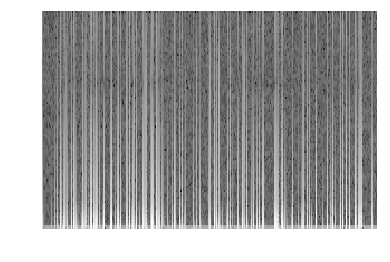

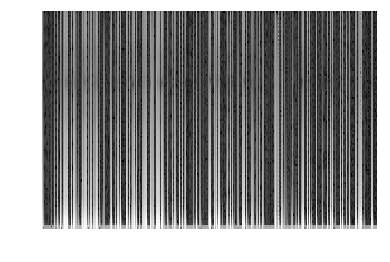

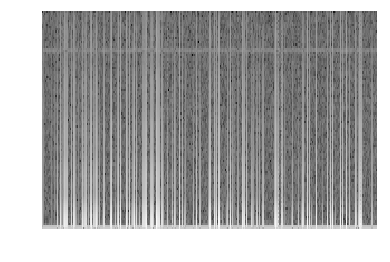

In [8]:
test_class.save_single_image(data=df_list[0], fs=100, NFFT=200)

In [9]:
test_class.save_multi_images(df_list=df_list, fs=100, NFFT=200)

20571 started
start getting data
complete getting data.
fft_plot started.
arranging ticks.
done arranging
creating subplot.
20572 started
start getting data
complete getting data.
20573 started
start getting data
fft_plot started.
arranging ticks.
done arranging
creating subplot.
complete getting data.
fft_plot started.
arranging ticks.
done arranging
creating subplot.


Process ForkPoolWorker-23:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
  File "/home/knusslab/anaconda3/envs/JupyterServer/lib/python3.6/multiprocessing/process.py"

KeyboardInterrupt: 